In [30]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import torchvision
import torchvision.transforms as transforms

In [31]:
@dataclass
class LIFNeuron:
    """Одиночный нейрон для изучения динамики (как в примере)"""
    tau_m: float = 20.0    # Постоянная времени мембраны (мс)
    v_rest: float = -70.0  # Потенциал покоя (мВ)
    v_thresh: float = -55.0 # Пороговый потенциал (мВ)
    v_reset: float = -75.0 # Потенциал сброса (мВ)
    r_m: float = 10.0      # Мембранное сопротивление (МОм)
    tau_ref: float = 4.0   # Рефрактерный период (мс)

    def __post_init__(self):
        self.v = self.v_rest
        self.refractory_until = 0
        self.spike_times = []

    def step(self, I_inj: float, dt: float, t: float) -> bool:
        if t < self.refractory_until:
            self.v = self.v_reset
            return False

        dv = (-(self.v - self.v_rest) + self.r_m * I_inj) / self.tau_m
        self.v += dv * dt

        if self.v >= self.v_thresh:
            self.v = self.v_reset
            self.refractory_until = t + self.tau_ref
            self.spike_times.append(t)
            return True
        return False




In [32]:

# ==========================================
# 2. ВИЗУАЛИЗАЦИЯ ДИНАМИКИ (Задание 1.2)
# ==========================================
def analyze_single_neuron():
    print("--- Анализ динамики одиночного LIF-нейрона ---")
    dt = 0.1
    T = 200
    t_range = np.arange(0, T, dt)
    neuron = LIFNeuron()
    
    # Разные типы токов
    currents = {
        "Подпороговый": np.ones_like(t_range) * 2.0,
        "Надпороговый": np.ones_like(t_range) * 5.0,
        "Шумовой": np.ones_like(t_range) * 4.0 + np.random.randn(len(t_range)) * 1.5
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    for idx, (name, I_inj) in enumerate(currents.items()):
        neuron.v = neuron.v_rest
        neuron.spike_times = []
        v_trace = []
        
        for i, t in enumerate(t_range):
            spike = neuron.step(I_inj[i], dt, t)
            v_trace.append(neuron.v)
            
        axes[idx].plot(t_range, v_trace, label=name)
        axes[idx].axhline(neuron.v_thresh, color='r', linestyle='--', alpha=0.5)
        axes[idx].set_ylabel('V (мВ)')
        axes[idx].legend(loc='upper right')
        axes[idx].grid(True)
        
    axes[-1].set_xlabel('Время (мс)')
    plt.suptitle("Реакция LIF-нейрона на разные входные токи")
    plt.tight_layout()
    plt.show()



In [33]:
class LIFLayer:
    def __init__(self, n_neurons: int, tau_m=20.0, v_thresh=-55.0, v_rest=-70.0, v_reset=-75.0, tau_ref=4.0):
        self.n_neurons = n_neurons
        self.tau_m = tau_m
        self.v_thresh = v_thresh
        self.v_rest = v_rest
        self.v_reset = v_reset
        self.tau_ref = tau_ref
        
        # Состояния
        self.v = np.full(n_neurons, v_rest)
        self.refractory_timer = np.zeros(n_neurons)
        self.spike_train = []
        
        # АДАПТИВНЫЙ ПОРОГ для каждого нейрона (homeostasis)
        self.v_thresh_array = np.full(n_neurons, v_thresh)
        self.spike_count_per_epoch = np.zeros(n_neurons)
        
    def reset(self):
        self.v = np.full(self.n_neurons, self.v_rest)
        self.refractory_timer = np.zeros(self.n_neurons)
        self.spike_train = [[] for _ in range(self.n_neurons)]
        self.spike_count_per_epoch = np.zeros(self.n_neurons)

    def step(self, I_inj: np.ndarray, dt: float, t: float) -> np.ndarray:
        self.refractory_timer = np.maximum(0, self.refractory_timer - dt)
        in_refractory = self.refractory_timer > 0
        
        dv = (-(self.v - self.v_rest) + I_inj) / self.tau_m
        self.v[~in_refractory] += dv[~in_refractory] * dt
        
        # Используем адаптивный порог!
        spiked = self.v >= self.v_thresh_array
        spiked = spiked & (~in_refractory)
        
        self.v[spiked] = self.v_reset
        self.refractory_timer[spiked] = self.tau_ref
        
        if np.any(spiked):
            indices = np.where(spiked)[0]
            for idx in indices:
                self.spike_train[idx].append(t)
            self.spike_count_per_epoch[spiked] += 1
                
        return spiked.astype(float)
    
    def adjust_thresholds(self, target_spikes=50):
        """Адаптирует пороги после каждой эпохи"""
        for i in range(self.n_neurons):
            if self.spike_count_per_epoch[i] > target_spikes * 1.5:
                self.v_thresh_array[i] += 1.0  # Повышаем порог
            elif self.spike_count_per_epoch[i] < target_spikes * 0.5:
                self.v_thresh_array[i] -= 0.2
        
        # Ограничиваем порог
        self.v_thresh_array = np.clip(self.v_thresh_array, -60, -40)
        print(f"  Пороги нейронов: {self.v_thresh_array.astype(int)}")

In [34]:
# ==========================================
# 4. КОДИРОВАНИЕ MNIST (Rate Coding)
# ==========================================

def load_mnist_subset(train_samples=1000, test_samples=200):
    """Загружает MNIST и возвращает уменьшенный набор для быстрой демонстрации"""
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    # Нормализуем в [0, 1] для вероятности спайков
    transform_rate = transforms.Compose([transforms.ToTensor()]) 
    
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_rate)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_rate)

    # Берем подмножество
    train_indices = np.random.choice(len(train_dataset), train_samples, replace=False)
    test_indices = np.random.choice(len(test_dataset), test_samples, replace=False)
    
    X_train = np.array([train_dataset[i][0].flatten() for i in train_indices])
    y_train = np.array([train_dataset[i][1] for i in train_indices])
    
    X_test = np.array([test_dataset[i][0].flatten() for i in test_indices])
    y_test = np.array([test_dataset[i][1] for i in test_indices])
    
    return X_train, y_train, X_test, y_test

def rate_encoding(image: np.ndarray, time_window: int, dt: float) -> np.ndarray:
    n_pixels = image.shape[0]
    n_steps = int(time_window / dt)
    
    # УМЕРЕННЫЙ контраст
    image_contrast = np.clip(image * 1.0, 0, 1)
    probs = np.clip(image_contrast * dt * 40, 0, 1)  # 40 Hz max rate
    
    spikes = (np.random.rand(n_steps, n_pixels) < probs[:, None].T).astype(float)
    return spikes



In [35]:
# ==========================================
# 5. ПРАВИЛО STDP
# ==========================================

class STDP:
    def __init__(self, n_pre: int, n_post: int, lr=0.01, tau_plus=20.0, tau_minus=20.0, w_max=2.0):
        # РАЗНЫЕ начальные веса для каждого нейрона
        self.weights = np.zeros((n_pre, n_post))
        
        for j in range(n_post):
            # Каждый нейрон получает РАЗНЫЙ случайный паттерн
            self.weights[:, j] = np.random.rand(n_pre) * 0.5 + 0.1
        
        self.lr = lr
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus
        self.w_max = w_max
        
        self.pre_trace = np.zeros(n_pre)
        self.post_trace = np.zeros(n_post)
        self.tau_trace = 20.0

    def update(self, pre_spikes: np.ndarray, post_spikes: np.ndarray, dt: float):
        """
        Обновление весов на основе текущих спайков и трейсеров.
        pre_spikes, post_spikes: бинарные векторы (1 если спайк на этом шаге)
        """
        # Затухание трейсеров
        self.pre_trace *= np.exp(-dt / self.tau_trace)
        self.post_trace *= np.exp(-dt / self.tau_trace)
        
        # Увеличение трейсера при спайке
        self.pre_trace += pre_spikes
        self.post_trace += post_spikes
        
        # STDP Update Rule (Упрощенная версия на основе трейсеров)
        # Delta w = lr * (pre_trace * post_spike - post_trace * pre_spike)
        dw = self.lr * (np.outer(self.pre_trace, post_spikes) - np.outer(pre_spikes, self.post_trace))
        
        self.weights += dw
        # Ограничение весов (clip)
        self.weights = np.clip(self.weights, 0, self.w_max)



In [36]:
# ==========================================
# 6. СЕТЬ И ОБУЧЕНИЕ
# ==========================================

class SNNClassifier:
    def __init__(self, n_input=784, n_output=10, sim_time=200, dt=1.0):
        self.n_input = n_input
        self.n_output = n_output
        self.sim_time = sim_time
        self.dt = dt
        self.n_steps = int(sim_time / dt)
        
        
        # Слой вывода с ОПТИМИЗИРОВАННЫМИ параметрами
        self.output_layer = LIFLayer(
            n_output, 
            tau_m=20.0,
            v_thresh=-55.0,
            v_rest=-70.0,
            v_reset=-70.0,
            tau_ref=3.0
        )
        
        
        # STDP с УВЕЛИЧЕННЫМ learning rate
        self.stdp = STDP(n_input, n_output, lr=0.005, w_max=1.5)
        
        # Усиленное латеральное торможение
        self.inhibition_strength = 15.0

    def train_step(self, image: np.ndarray, label: int):
        input_spikes = rate_encoding(image, self.sim_time, self.dt)
        
        self.output_layer.reset()
        total_energy = 0
        spike_counts = np.zeros(self.n_output)
        
        # СЛАБЫЙ teacher forcing - помогает специализации
        teacher_current = np.zeros(self.n_output)
        teacher_current[label] = 5.0 
        
        for t_step in range(self.n_steps):
            t = t_step * self.dt
            current_spikes = input_spikes[t_step]
            
            # Ток + teacher signal
            I_inj = np.dot(current_spikes, self.stdp.weights) * 3.0
            I_inj += teacher_current  # ДОБАВЛЕНО
            
            post_spikes = self.output_layer.step(I_inj, self.dt, t)

            if np.sum(post_spikes) > 1:
                winner = np.argmax(post_spikes)
                post_spikes[:] = 0
                post_spikes[winner] = 1

            spike_counts += post_spikes
            
            if np.any(post_spikes):
                self.output_layer.v[post_spikes == 0] = self.output_layer.v_rest

            self.stdp.update(current_spikes, post_spikes, self.dt)
            total_energy += np.sum(post_spikes)
            
        prediction = np.argmax([len(st) for st in self.output_layer.spike_train])

        return prediction, total_energy, spike_counts

    def predict(self, image: np.ndarray):
        input_spikes = rate_encoding(image, self.sim_time, self.dt)
        self.output_layer.reset()
        
        for t_step in range(self.n_steps):
            t = t_step * self.dt
            current_spikes = input_spikes[t_step]
            I_inj = np.dot(current_spikes, self.stdp.weights) * 3.0
            self.output_layer.step(I_inj, self.dt, t)
            
        prediction = np.argmax([len(st) for st in self.output_layer.spike_train])
        return prediction



In [37]:
def debug_training():
    """Проверка что нейроны вообще работают"""
    print("\n=== ОТЛАДКА: Проверка генерации спайков ===")
    X_train, y_train, X_test, y_test = load_mnist_subset(train_samples=10, test_samples=5)
    
    snn = SNNClassifier(n_input=784, n_output=10, sim_time=100, dt=1.0)
    
    print(f"Яркость пикселей: min={X_train[0].min():.3f}, max={X_train[0].max():.3f}")
    print(f"Средняя яркость: {X_train[0].mean():.3f}")
    
    pred, energy, counts = snn.train_step(X_train[0], y_train[0])
    
    print(f"\nПервое изображение (цифра {y_train[0]}):")
    print(f"Сгенерировано спайков: {energy}")
    print(f"Распределение по нейронам: {counts.astype(int)}")
    print(f"Предсказание: {pred}, Правильный ответ: {y_train[0]}")
    
    if energy == 0:
        print("\n⚠️  ВНИМАНИЕ: Нейроны не спайкуют!")
        # Тест с искусственно усиленным входом
        test_input = np.ones(784) * 0.5
        I_test = np.dot(test_input, snn.stdp.weights) * 5.0
        print(f"Средний входной ток: {I_test.mean():.3f}")
        print(f"Максимальный ток: {I_test.max():.3f}")
        print(f"Минимальный ток: {I_test.min():.3f}")
    else:
        print("✓ Нейроны работают!")
    
    return snn


def visualize_weights(snn, epoch):
    """Визуализация весов сети"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()
    
    for i in range(10):
        weights = snn.stdp.weights[:, i].reshape(28, 28)
        axes[i].imshow(weights, cmap='hot')
        axes[i].set_title(f"Нейрон {i}")
        axes[i].axis('off')
    
    plt.suptitle(f"Веса сети (эпоха {epoch})")
    plt.tight_layout()
    plt.show()



=== ОТЛАДКА: Проверка генерации спайков ===
Яркость пикселей: min=0.000, max=1.000
Средняя яркость: 0.135

Первое изображение (цифра 3):
Сгенерировано спайков: 47.0
Распределение по нейронам: [ 4 21  0  0  0  0  0 22  0  0]
Предсказание: 1, Правильный ответ: 3
✓ Нейроны работают!
--- Анализ динамики одиночного LIF-нейрона ---


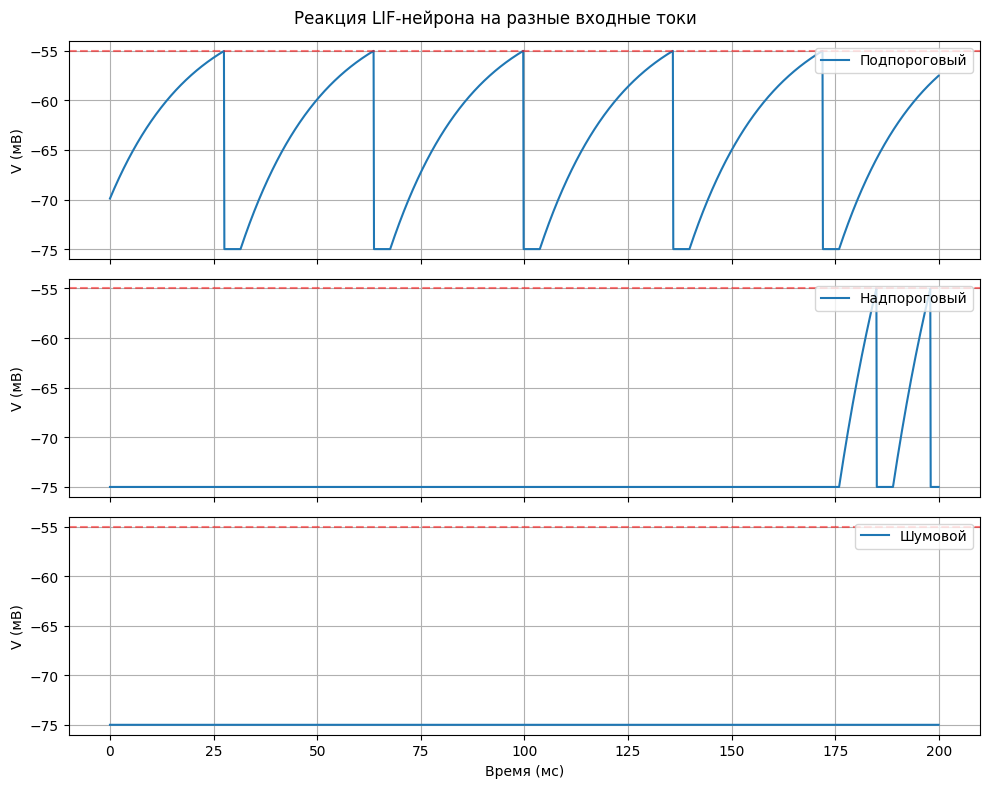


--- Загрузка MNIST и обучение SNN ---
Начало обучения...
Эпоха 1: Адаптация порогов...
  Пороги нейронов: [-55 -55 -55 -55 -55 -55 -55 -55 -55 -55]
Эпоха 1: Точность (Train) = 0.12, Энергия = 44070 спайков
Эпоха 2: Адаптация порогов...
  Пороги нейронов: [-54 -54 -54 -55 -54 -54 -55 -55 -54 -54]
Эпоха 2: Точность (Train) = 0.14, Энергия = 44026 спайков


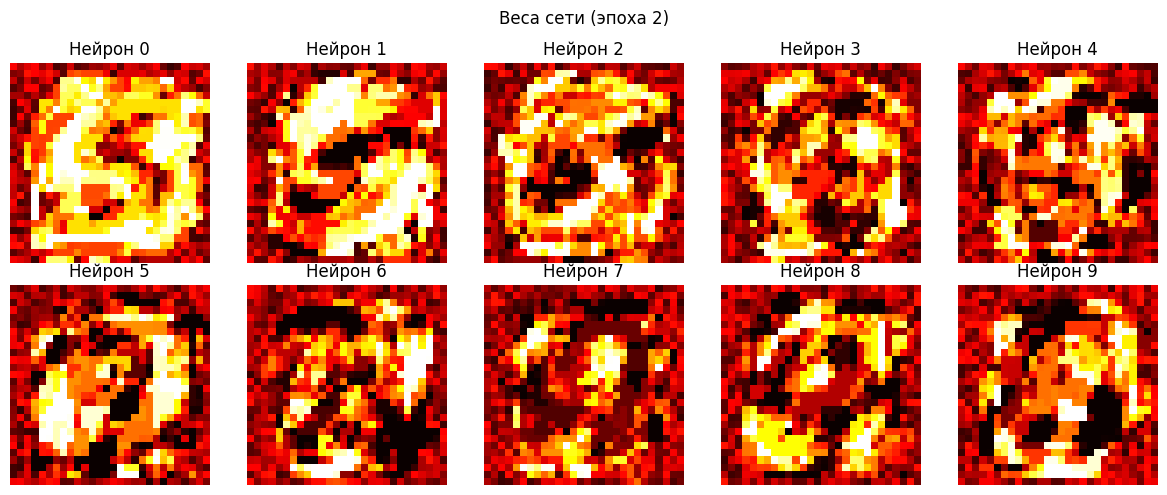

Эпоха 3: Адаптация порогов...
  Пороги нейронов: [-54 -54 -54 -55 -54 -54 -55 -55 -54 -54]
Эпоха 3: Точность (Train) = 0.12, Энергия = 43648 спайков
Эпоха 4: Адаптация порогов...
  Пороги нейронов: [-54 -54 -54 -55 -54 -54 -55 -55 -54 -54]
Эпоха 4: Точность (Train) = 0.14, Энергия = 42827 спайков


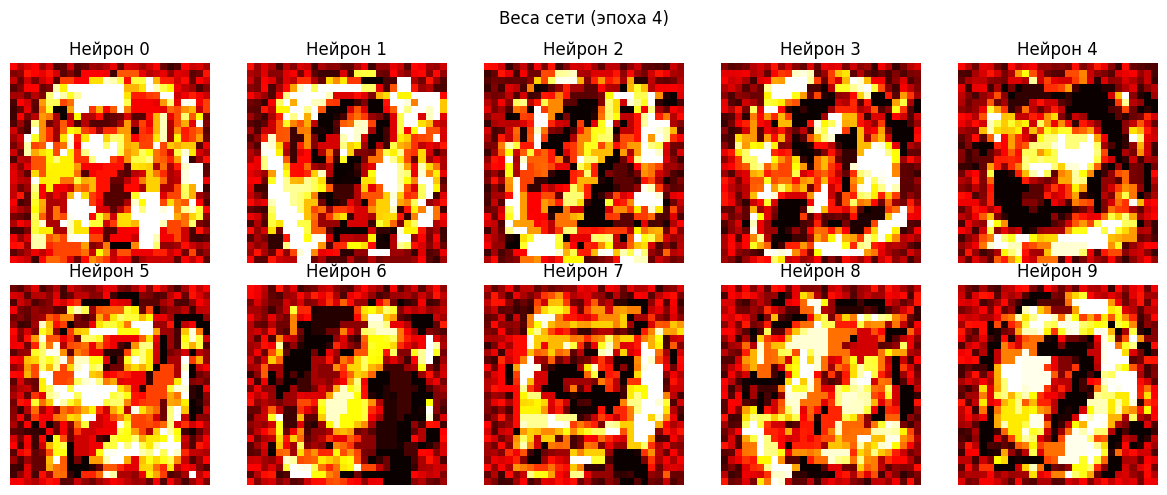

Эпоха 5: Адаптация порогов...
  Пороги нейронов: [-54 -54 -54 -54 -54 -54 -54 -54 -53 -54]
Эпоха 5: Точность (Train) = 0.12, Энергия = 43841 спайков
Эпоха 6: Адаптация порогов...
  Пороги нейронов: [-53 -53 -53 -53 -53 -53 -54 -53 -52 -53]
Эпоха 6: Точность (Train) = 0.13, Энергия = 43741 спайков


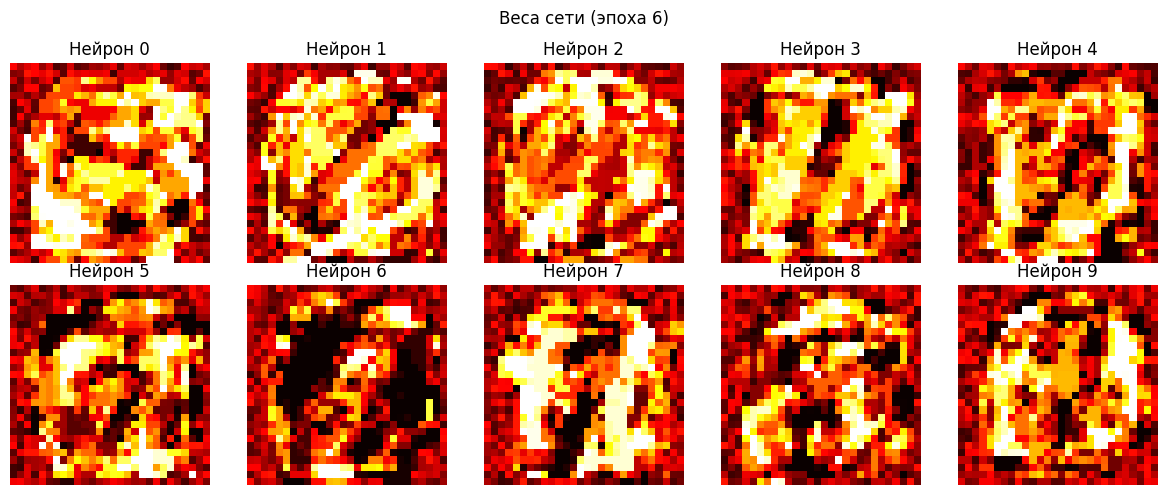

Эпоха 7: Адаптация порогов...
  Пороги нейронов: [-52 -52 -52 -53 -52 -53 -54 -52 -52 -52]
Эпоха 7: Точность (Train) = 0.15, Энергия = 42542 спайков
Эпоха 8: Адаптация порогов...
  Пороги нейронов: [-52 -51 -52 -53 -52 -53 -54 -52 -52 -52]
Эпоха 8: Точность (Train) = 0.12, Энергия = 42449 спайков


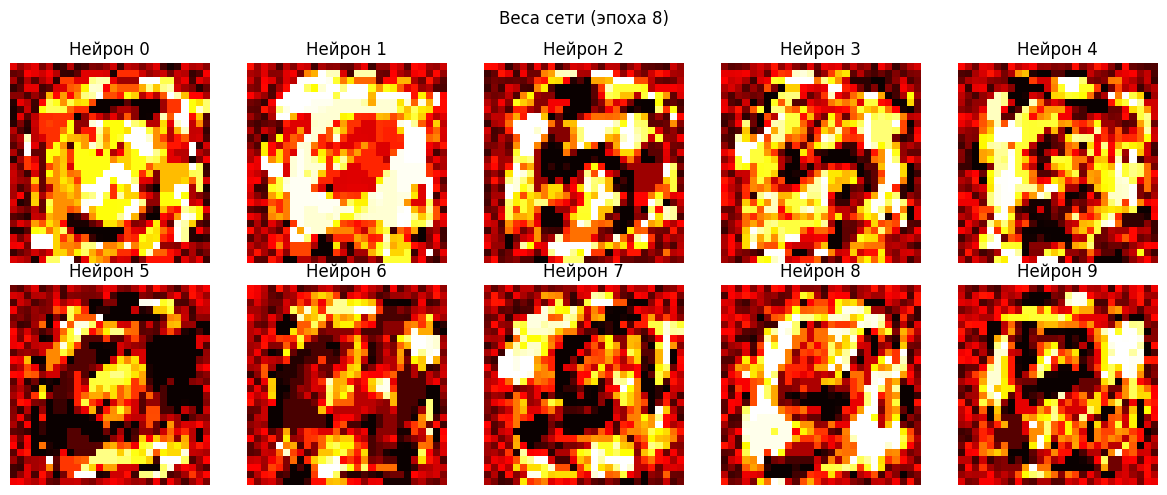

Эпоха 9: Адаптация порогов...
  Пороги нейронов: [-52 -51 -52 -53 -52 -53 -54 -52 -52 -52]
Эпоха 9: Точность (Train) = 0.13, Энергия = 41843 спайков
Эпоха 10: Адаптация порогов...
  Пороги нейронов: [-52 -50 -52 -53 -52 -53 -54 -52 -52 -52]
Эпоха 10: Точность (Train) = 0.11, Энергия = 41620 спайков


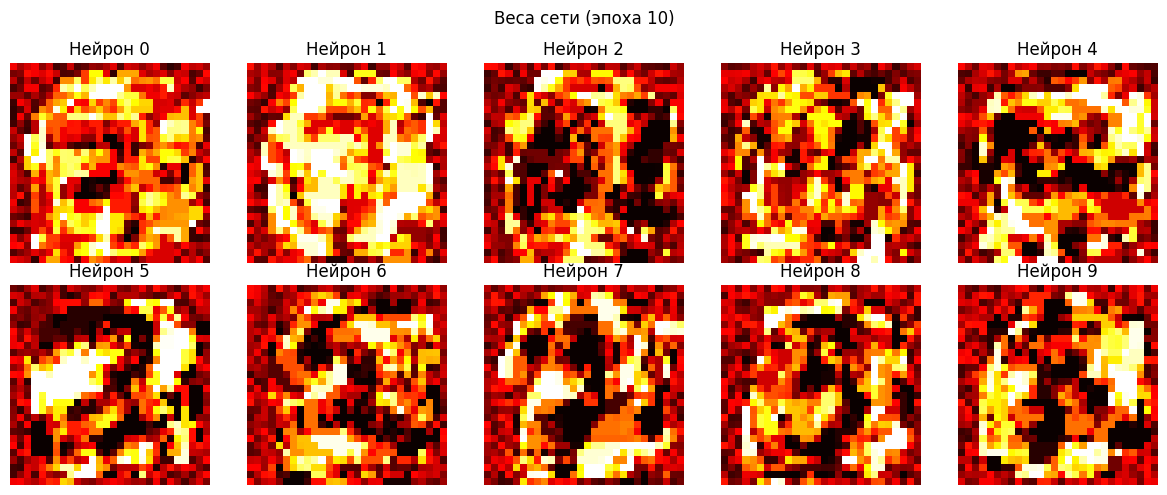


=== Анализ специализации нейронов ===
Распределение: нейрон -> классы (строка = нейрон, столбец = класс)
[[50 27 52 42 42 42 41 45 54 57]
 [ 0 25  0  0  4  2  2 11  0  2]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Нейрон 1: специализирован на классе 1 (25.0/46.0)
Нейрон 3: специализирован на классе 1 (2.0/2.0)

Всего специализированных нейронов: 2/10

Итоговая точность на тесте: 0.18


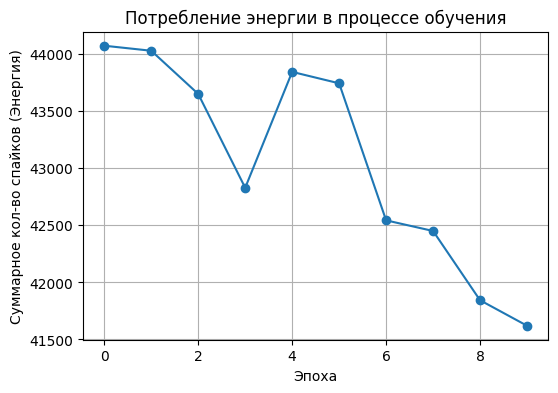


--- Анализ устойчивости к шуму ---
Шум sigma=0.0: Точность = 0.18
Шум sigma=0.1: Точность = 0.14
Шум sigma=0.2: Точность = 0.14
Шум sigma=0.3: Точность = 0.14


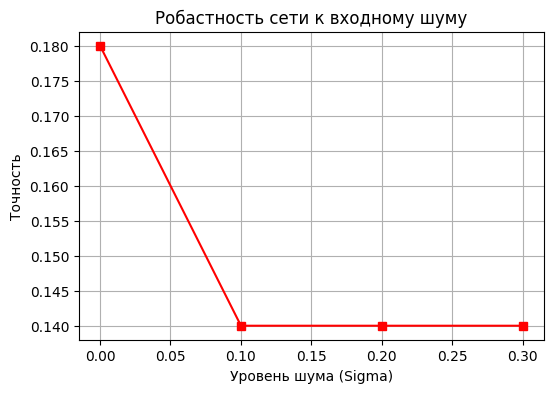

In [38]:
# ==========================================
# 7. ЗАПУСК И АНАЛИЗ (Main)
# ==========================================

if __name__ == "__main__":
    # 0. ОТЛАДКА: Проверка работы нейронов
    debug_snn = debug_training()
    
    # 1. Анализ одиночного нейрона
    analyze_single_neuron()
    
    # 2. Подготовка данных (Ограничим выборку для скорости демонстрации)
    print("\n--- Загрузка MNIST и обучение SNN ---")
    X_train, y_train, X_test, y_test = load_mnist_subset(train_samples=500, test_samples=100)
    
    # Нормализация данных в [0, 1] для rate coding
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    

    # 4. Обучение
    energies = []
    print("Начало обучения...")
    snn = SNNClassifier(n_input=784, n_output=10, sim_time=150, dt=1.0)
    
    for epoch in range(10):
        correct = 0
        total_energy_epoch = 0
        
        indices = np.random.permutation(len(X_train))
        
        for i in indices:
            pred, energy, _ = snn.train_step(X_train[i], y_train[i])
            if pred == y_train[i]:
                correct += 1
            total_energy_epoch += energy
        
        # АДАПТАЦИЯ ПОРОГОВ после каждой эпохи
        print(f"Эпоха {epoch+1}: Адаптация порогов...")
        snn.output_layer.adjust_thresholds(target_spikes=30)
        
        # ТОЛЬКО clip, БЕЗ нормализации
        snn.stdp.weights = np.clip(snn.stdp.weights, 0, snn.stdp.w_max)
        
        acc = correct / len(X_train)
        energies.append(total_energy_epoch)
        print(f"Эпоха {epoch+1}: Точность (Train) = {acc:.2f}, Энергия = {total_energy_epoch:.0f} спайков")
        
        # Визуализация весов каждые 2 эпохи
        if (epoch + 1) % 2 == 0:
            visualize_weights(snn, epoch + 1)


    # АНАЛИЗ: какие нейроны на что реагируют
    print("\n=== Анализ специализации нейронов ===")
    neuron_class_counts = np.zeros((10, 10))  # neuron x true_class
    
    for i in range(len(X_train)):
        input_spikes = rate_encoding(X_train[i], 300, 1.0)
        snn.output_layer.reset()
        
        for t_step in range(300):
            current_spikes = input_spikes[t_step]
            I_inj = np.dot(current_spikes, snn.stdp.weights) * 5.0
            snn.output_layer.step(I_inj, 1.0, t_step)
        
        spike_counts = [len(st) for st in snn.output_layer.spike_train]
        winner = np.argmax(spike_counts)
        true_class = y_train[i]
        neuron_class_counts[winner, true_class] += 1
    
    print("Распределение: нейрон -> классы (строка = нейрон, столбец = класс)")
    print(neuron_class_counts.astype(int))
    
    # Сколько нейронов выучили разные классы
    specialized_neurons = 0
    for n in range(10):
        dominant_class = np.argmax(neuron_class_counts[n])
        count = neuron_class_counts[n, dominant_class]
        total = neuron_class_counts[n].sum()
        if total > 0 and count / total > 0.5:
            specialized_neurons += 1
            print(f"Нейрон {n}: специализирован на классе {dominant_class} ({count}/{total})")
    
    print(f"\nВсего специализированных нейронов: {specialized_neurons}/10")
        
    # 5. Тестирование
    correct = 0
    for i in range(len(X_test)):
        pred = snn.predict(X_test[i])
        if pred == y_test[i]:
            correct += 1
    test_acc = correct / len(X_test)
    print(f"\nИтоговая точность на тесте: {test_acc:.2f}")
    
    # 6. Анализ Энергии
    plt.figure(figsize=(6,4))
    plt.plot(energies, marker='o')
    plt.xlabel('Эпоха')
    plt.ylabel('Суммарное кол-во спайков (Энергия)')
    plt.title('Потребление энергии в процессе обучения')
    plt.grid(True)
    plt.show()
    
    # 7. Устойчивость к шуму (Анализ)
    print("\n--- Анализ устойчивости к шуму ---")
    noise_levels = [0.0, 0.1, 0.2, 0.3]
    acc_noise = []
    
    for noise in noise_levels:
        correct = 0
        for i in range(len(X_test)):
            # Добавляем гауссовский шум к входному изображению
            noisy_img = np.clip(X_test[i] + np.random.normal(0, noise, X_test[i].shape), 0, 1)
            pred = snn.predict(noisy_img)
            if pred == y_test[i]:
                correct += 1
        acc_noise.append(correct / len(X_test))
        print(f"Шум sigma={noise}: Точность = {acc_noise[-1]:.2f}")
        
    plt.figure(figsize=(6,4))
    plt.plot(noise_levels, acc_noise, marker='s', color='red')
    plt.xlabel('Уровень шума (Sigma)')
    plt.ylabel('Точность')
    plt.title('Робастность сети к входному шуму')
    plt.grid(True)
    plt.show()